In [100]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import invgamma
import utils
import hashlib
from sklearn.mixture import GaussianMixture
from learn_diagonal_gauss_fs import bayesGMM_FS as bayesGM
from sklearn.metrics.cluster import adjusted_rand_score
import time
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [101]:
N = 500
K = 2
D = 2

# seed = 4586
seed = 11644
# seed = np.random.randint(1000, 2**16)
np.random.seed(seed)
print(seed)

11644


I'm using Normal-Inverse-chi2 according to following reparametrization of the normal-Inverse-Gamma hyperparameters. Ref: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf

m0_true is MU0\
k0_true is KAPPA0\
v0_true is 2 x ALPHA0\
s0_true is 2 x BETA0

In [102]:
m0_true = np.random.uniform(2, 50, (K, D))
k0_true = np.random.uniform(1, 1.5, K)
S0_true = np.random.uniform(0.025, 0.03, (K , D))
v0_true = np.random.randint(1, 3, K)

# m0_true = np.random.uniform(-1, 1, D)
# k0_true = np.random.uniform(0, 0.5)
# S0_true = np.random.uniform(0, 2, D)
# v0_true = np.random.randint(1, 3)

alpha_true = 1.0

print([np.min(m0_true), np.max(m0_true)])
print([np.min(S0_true), np.max(S0_true)])

[5.601443705685254, 47.77635409663541]
[0.025061271101322745, 0.029631076223354938]


#### Sample mu and sigma

In [103]:
mu = np.zeros((K, D), float)
sigma = np.zeros((K, D), float)
for k in range(K):
    for j in range(D):
        mu[k, j] = norm.rvs(m0_true[k, j], S0_true[k, j]/(k0_true[k]*v0_true[k]))
        sigma[k, j] = invgamma.rvs(v0_true[k]/2, S0_true[k, j]/2)
        # mu[k, j] = np.random.normal(m0_true[j], S0_true[j]/(k0_true*v0_true))
        # sigma[k, j] = invgamma.rvs(v0_true/2, S0_true[j]/2)

print([np.min(mu), np.max(mu)])
print([np.min(sigma), np.max(sigma)])

[5.607383844596348, 47.75250207910416]
[1.7647419955792754, 5.897757403257889]


#### Generate data

[-1.3874408915062952, 62.654789422308205]


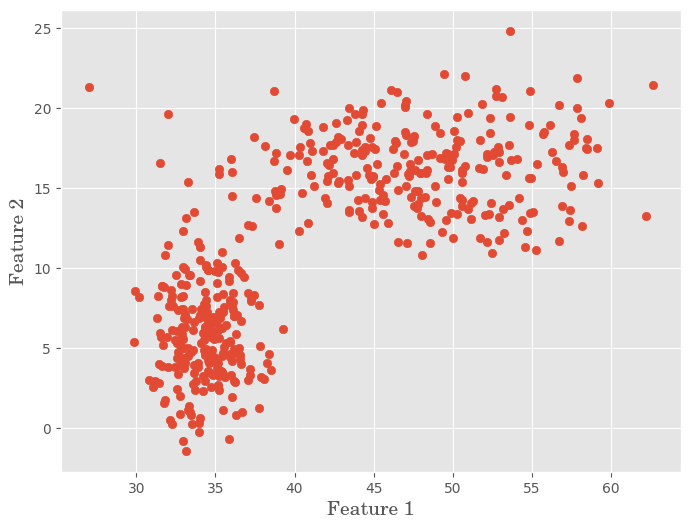

In [104]:
mixing_probabilities = np.random.dirichlet([alpha_true]*K, size=1)[0]
z_true = np.random.choice(K, p=mixing_probabilities, size=N)

z_true = np.random.randint(0, K, N)

X = np.zeros((N, D))

for i in range(N):
    for j in range(D):
        for k in range(K):
            if z_true[i] == k:
                X[i, j] = np.random.normal(mu[k, j], sigma[k, j])

X[:, [0, 1]] = X[:, [1, 0]]

print([np.min(X), np.max(X)])

plt.figure(figsize=(8, 6))  # Adjust the size of the plot
plt.style.use('ggplot')
plt.xlabel('Feature 1', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
plt.ylabel('Feature 2',  fontdict={'fontsize': 14, 'fontfamily': 'C059'})
plt.scatter(X[:, 0], X[:, 1])
# plt.savefig('thesis-results/2D-mixed.png', dpi=300)


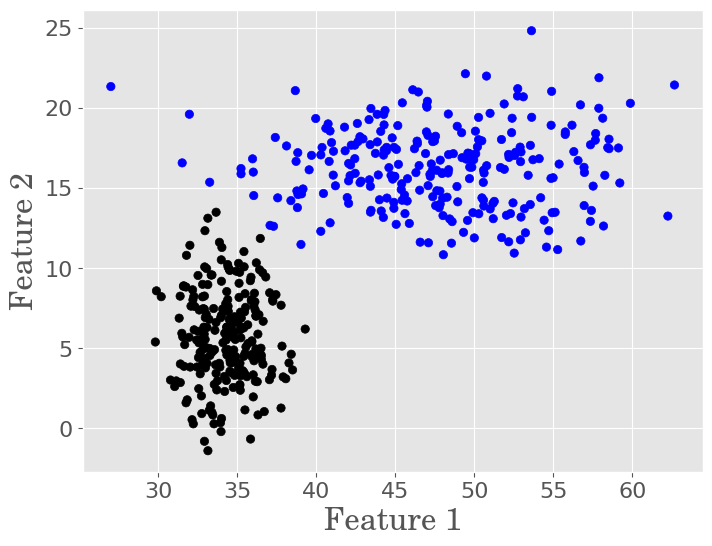

In [105]:
# heatmap = sns.heatmap(X[np.argsort(z_true)])

colors = np.array([x for x in "kbgrbgcmykbgrcmykbgrcmyk"])

plt.figure(figsize=(8, 6))  # Adjust the size of the plot
plt.style.use('ggplot')
plt.xlabel('Feature 1', fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.ylabel('Feature 2',  fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.scatter(X[:, 0], X[:, 1], color=colors[z_true].tolist())
plt.savefig('thesis-results/2D-true.png', dpi=300)


In [106]:
sigma

array([[3.06865603, 1.764742  ],
       [2.55198423, 5.8977574 ]])

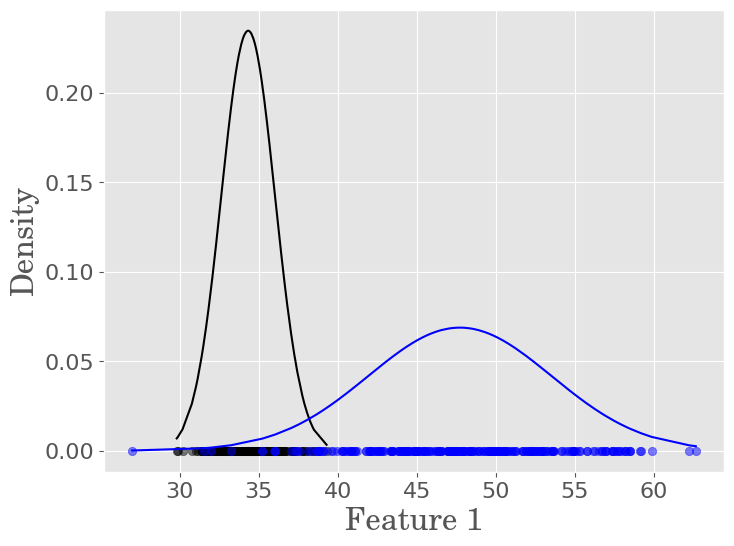

In [107]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate some sample data for two Gaussian mixtures

data = X[:, 0]
data1 = sorted(data[np.where(z_true == 0)])
data2 = sorted(data[np.where(z_true == 1)])

# Plot the 1D data as a scatter plot with different colors for each Gaussian mixture
plt.figure(figsize=(8, 6))
plt.scatter(data1, np.zeros_like(data1), color='k', alpha=0.5, label='Gaussian 1')
plt.scatter(data2, np.zeros_like(data2), color='b', alpha=0.5, label='Gaussian 2')


params = {'mean': [np.mean(data1), np.mean(data2)], 'std': [1.7, 5.8], 'weight': [1, 1]}  # Parameters for the two Gaussian mixtures

# for mean, std, weight, color in zip(params['mean'], params['std'], params['weight'], ['blue', 'red']):
density = norm.pdf(data1, np.mean(data1), 1.7) * weight
plt.plot(data1, density, color="k")

density = norm.pdf(data2, np.mean(data2), 5.8) * weight
plt.plot(data2, density, color="b")


plt.xlabel('Feature 1', fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.ylabel('Density',  fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.xlabel('Feature 1')
# plt.ylabel('Density')
# plt.title('1D Data and Density Distribution of Gaussian Mixtures')
# plt.legend()
plt.grid(True)
plt.savefig('thesis-results/2D-true-collapsed.png', dpi=300)

plt.show()


In [108]:
len(data)

500

In [109]:
mean1 = np.mean(data1)
mean2 = np.mean(data2)
var1 = np.var(data1)
var2 = np.var(data2)
print(mean1, mean2, var1, var2)

34.34037474741935 47.73195205968883 3.0366647000958453 37.34091856863127


In [110]:
mu

array([[ 5.60738384, 34.25761235],
       [16.45567746, 47.75250208]])

In [111]:
sigma

array([[3.06865603, 1.764742  ],
       [2.55198423, 5.8977574 ]])

In [112]:
### Save data and labels

filepath = f"dataHyperFS/{N}_{K}_{D}_{seed}_{hashlib.sha256(X.tobytes()).hexdigest()[:5]}"
print(utils.saveData(f"{filepath}.csv", X, remark="Data"))
print(utils.saveData(f"{filepath}.labels", z_true, remark="Labels"))

dataHyperFS/500_2_2_11644_c6a0f.csv
dataHyperFS/500_2_2_11644_c6a0f.labels


### Run scikit GMM before adding noise

In [113]:
## Run scikit GMM with only Gaussian Data

training_runs_EM = 30
best_gmm = GaussianMixture(n_components=K, n_init=training_runs_EM)
best_gmm.fit(X)
print(f"BIC: {best_gmm.bic(X)}\nK: {K}")
z_pred_EM = best_gmm.predict(X)

print("ARI:", round(adjusted_rand_score(z_true, z_pred_EM),3))

BIC: 5782.02231136908
K: 2
ARI: 1.0


### Add noise

In [123]:
nd = 1 # number of noisey features

[[0 1]
 [0 1]]


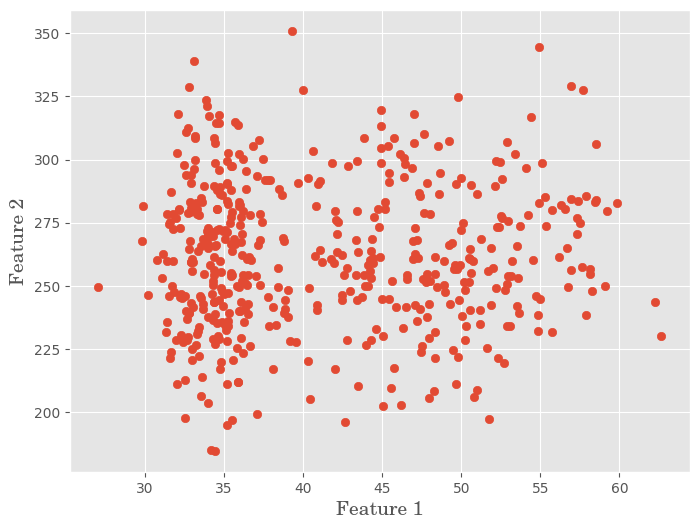

In [125]:
isLOCAL = False # global or local

true_features = np.ones((K, D), int)

if not isLOCAL:
    true_features[:, :nd] = np.zeros((K, nd), int)
else:
    for j in range(nd):
        rand_cluster = np.random.randint(0, 2, K)
        true_features[:, j] = rand_cluster

print(true_features)

true_features[:, [0, 1]] = true_features[:, [1, 0]]

X_noisey = X.copy()

X_mean = np.mean(X)
X_var = np.var(X)
for k in range(K):
    for j in range(D):
        if true_features[k][j] == 0:
            for i in range(N):
                if z_true[i] == k :
                    X_noisey[i, j] = np.random.normal(10*X_mean, 0.1*X_var)

plt.figure(figsize=(8, 6))  # Adjust the size of the plot
plt.style.use('ggplot')
plt.xlabel('Feature 1', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
plt.ylabel('Feature 2',  fontdict={'fontsize': 14, 'fontfamily': 'C059'})

plt.scatter(X_noisey[:, 0], X_noisey[:, 1])

plt.savefig('thesis-results/2D-mixed-noise.png', dpi=300)


In [126]:
X_var

276.8853618376995

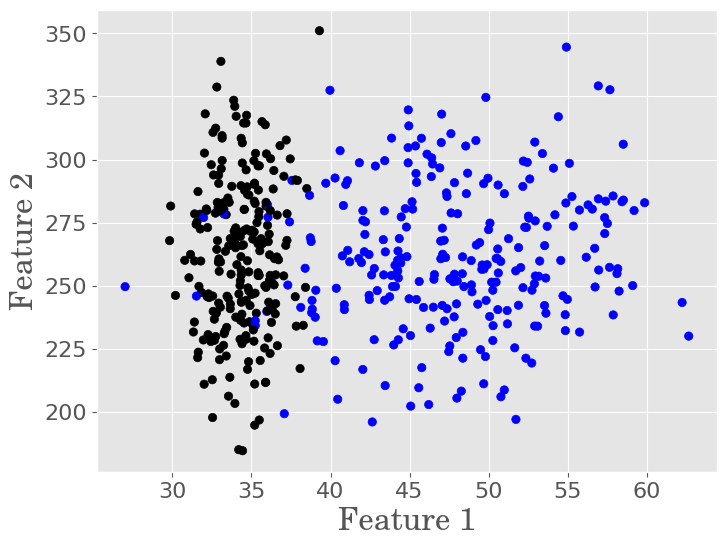

In [127]:
# heatmap = sns.heatmap(X[np.argsort(z_true)])
colors = np.array([x for x in "kbgrbgcmykbgrcmykbgrcmyk"])
plt.figure(figsize=(8, 6))  # Adjust the size of the plot
plt.style.use('ggplot')
plt.xlabel('Feature 1', fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.ylabel('Feature 2',  fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors[z_true].tolist())
plt.savefig('thesis-results/2D-true-noise.png', dpi=300)


In [128]:
### Save data

filepath = f"dataHyperFS/{N}_{K}_{D}_{seed}_{hashlib.sha256(X_noisey.tobytes()).hexdigest()[:5]}_noise_{nd}"
print(utils.saveData(f"{filepath}.csv", X_noisey, remark="Data"))
print(utils.saveData(f"{filepath}.features", true_features, remark="Data"))
print(utils.saveData(f"{filepath}.labels", z_true, remark="Labels"))

dataHyperFS/500_2_2_11644_108d0_noise_1.csv
dataHyperFS/500_2_2_11644_108d0_noise_1.features
dataHyperFS/500_2_2_11644_108d0_noise_1.labels


## Run Scikit-GMM

In [153]:
## Run scikit GMM with only Gaussian Data

training_runs_EM = 10

best_gmm = GaussianMixture(n_components=2, n_init=training_runs_EM)
best_gmm.fit(X_noisey)
print(f"K:{2}, BIC: {best_gmm.bic(X_noisey)}, ARI: {round(adjusted_rand_score(z_true, z_pred_EM),3)}")
z_pred_EM = best_gmm.predict(X_noisey)

print("ARI:", round(adjusted_rand_score(z_true, z_pred_EM),3))

K:2, BIC: 8357.799343875253, ARI: 0.556
ARI: 0.011


In [154]:
# plt.figure(figsize=(8, 6))  # Adjust the size of the plot
# plt.style.use('ggplot')
# plt.xlabel('Feature 1', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
# plt.ylabel('Feature 2',  fontdict={'fontsize': 14, 'fontfamily': 'C059'})

# colors_pref = (z_true == z_pred_EM).tolist()
# for i in range(len(ll)):
#     if colors_pref[i] == False:
#         colors_pref[i] = "r"
#     else:
#         colors_pref[i] = "g"


# # plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors[z_pred_EM].tolist())
# plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors_pref)

# # plt.savefig('thesis-results/2D-noise-EM.png', dpi=300)


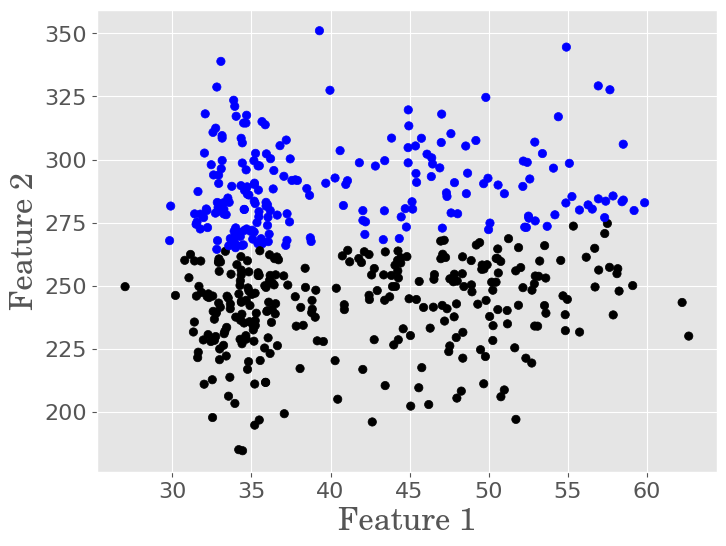

In [161]:
plt.figure(figsize=(8, 6))  # Adjust the size of the plot
plt.style.use('ggplot')
plt.xlabel('Feature 1', fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.ylabel('Feature 2',  fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors[z_pred_EM].tolist())
# plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors[np.where(z_true == z_pred_EM)].tolist())

plt.savefig('thesis-results/2D-noise-EM-poor.png', dpi=300)


## Run our Gaussian model

In [158]:
### Set the params

alpha = 1.0 
m_0 = np.zeros(D)
k_0 = 0.03 
v_0 = D + 3
S_0 = 0.3*v_0*np.ones(D)

K_initial = 2
iterations = 60
training_runs = 1

#### No Feature Selection

In [160]:
prior = utils.NIchi2(m_0, k_0, v_0, S_0)

Models = []
Results = []
    
FS = False

# initial_ass_seed = 25
# np.random.seed(initial_ass_seed)
for run in range(training_runs+20):
    print(f"\nRun:  {run+1}")
    starting_assignments = []

    while len(set(starting_assignments)) != K_initial:
        starting_assignments = np.random.randint(0, K_initial, N)
    
    bayesgmm = bayesGM(X_noisey, prior, alpha, starting_assignments, FS)
    gmmResult = bayesgmm.gibbs_sampler(iterations, run+2, toPrint=False, savePosterior=False, trueAssignments=z_true)
    
    Models.append(bayesgmm)
    Results.append(gmmResult)



Run:  1
59/60               
Run: 3, K:2, BIC: 2844.009187548579, logmax post: -1420.0045937742896, max_post_iter: 51
Final features:
[[1 1]
 [1 1]]

Run:  2
59/60               
Run: 4, K:2, BIC: 2852.3896037415025, logmax post: -1424.1948018707512, max_post_iter: 49
Final features:
[[1 1]
 [1 1]]

Run:  3
59/60               
Run: 5, K:2, BIC: 2856.43987476157, logmax post: -1426.219937380785, max_post_iter: 31
Final features:
[[1 1]
 [1 1]]

Run:  4
59/60               
Run: 6, K:2, BIC: 2852.316075867632, logmax post: -1424.158037933816, max_post_iter: 48
Final features:
[[1 1]
 [1 1]]

Run:  5
59/60               
Run: 7, K:2, BIC: 2858.859337040176, logmax post: -1427.429668520088, max_post_iter: 34
Final features:
[[1 1]
 [1 1]]

Run:  6
59/60               
Run: 8, K:2, BIC: 2844.769357078151, logmax post: -1420.3846785390756, max_post_iter: 16
Final features:
[[1 1]
 [1 1]]

Run:  7
59/60               
Run: 9, K:2, BIC: 2852.396130029527, logmax post: -1424.1980650147634, ma

ARI BIC LogMaxPost MAP_iter
0.868 2853 -1424 28
0.853 2864 -1430 36
0.853 2859 -1427 48
0.853 2848 -1422 17
0.853 2847 -1421 36
0.839 2831 -1413 19
0.831 2859 -1427 26
0.824 2860 -1428 59
0.824 2849 -1422 48
0.824 2848 -1422 13
0.817 2862 -1429 26
0.817 2861 -1428 10
0.817 2852 -1424 7
0.81 2858 -1427 33
0.81 2856 -1426 11
0.81 2854 -1425 34
0.795 2866 -1431 35
0.795 2857 -1426 40
0.795 2853 -1424 23
0.788 2861 -1428 44
0.774 2849 -1422 10


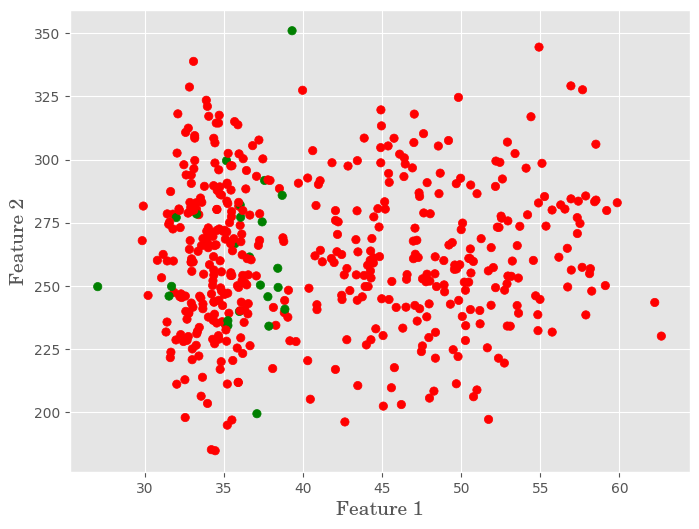

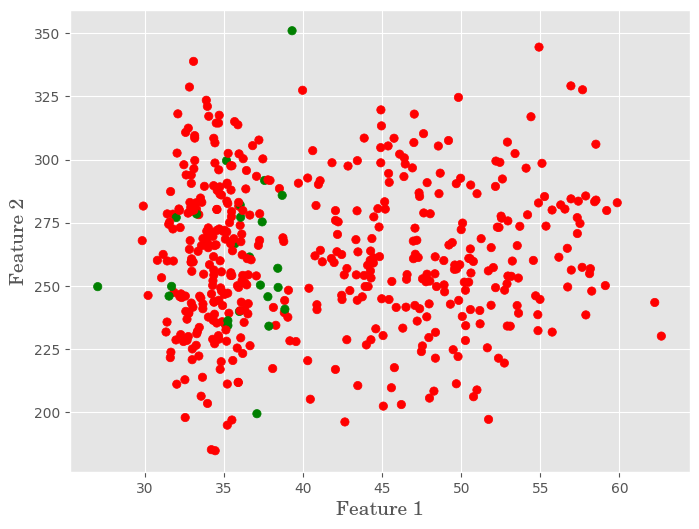

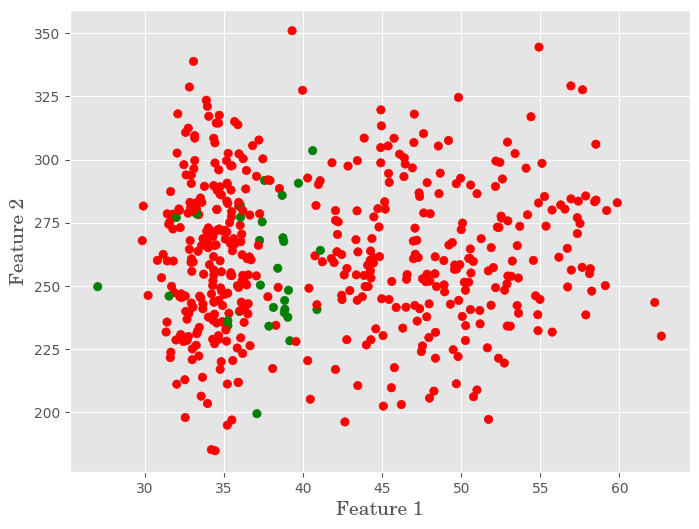

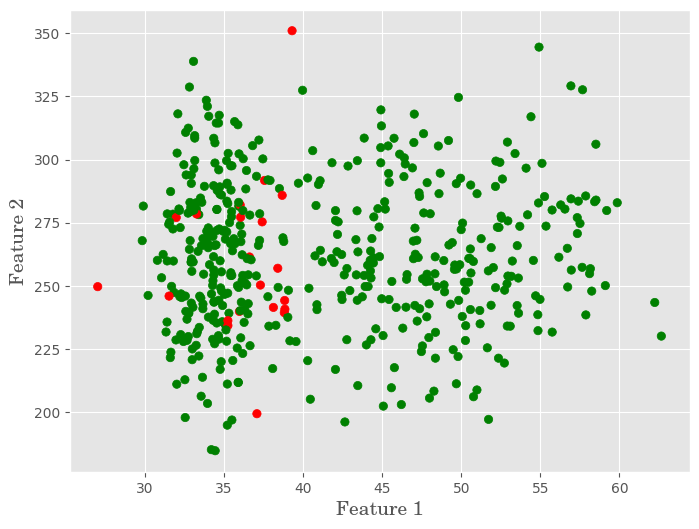

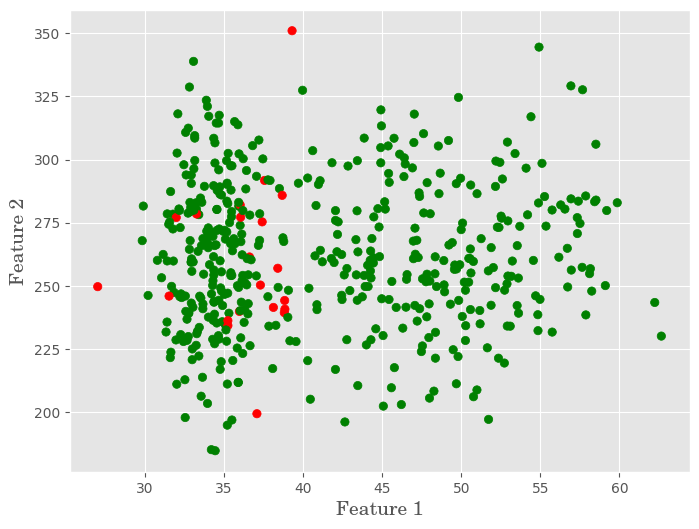

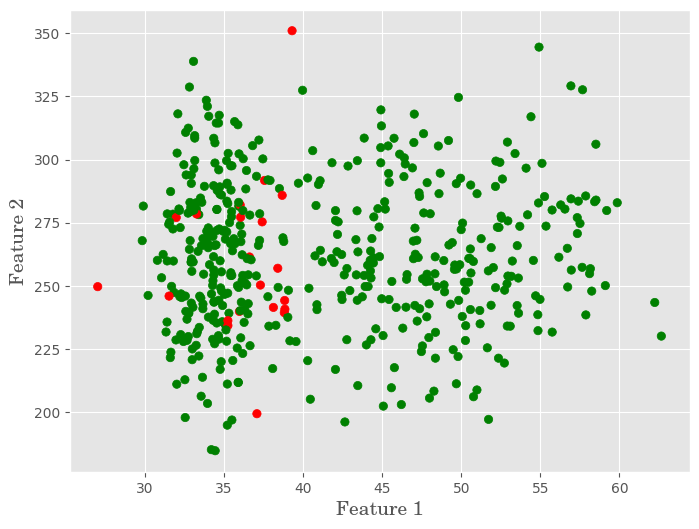

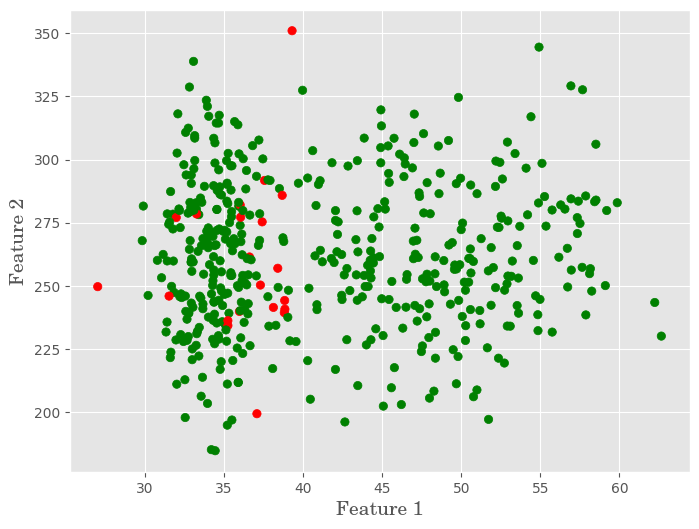

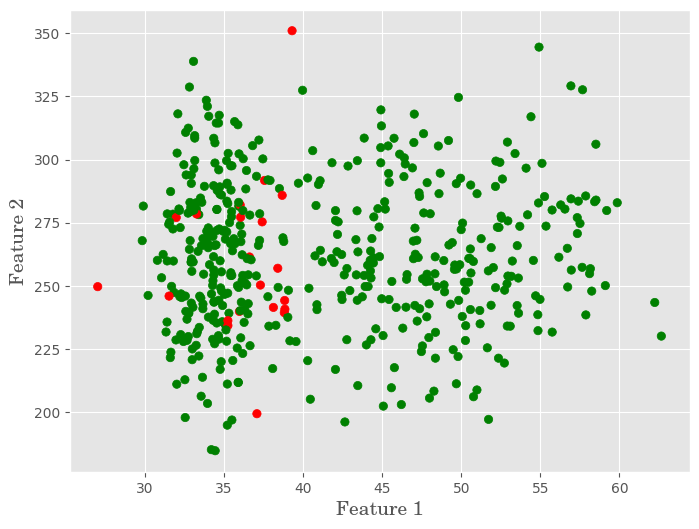

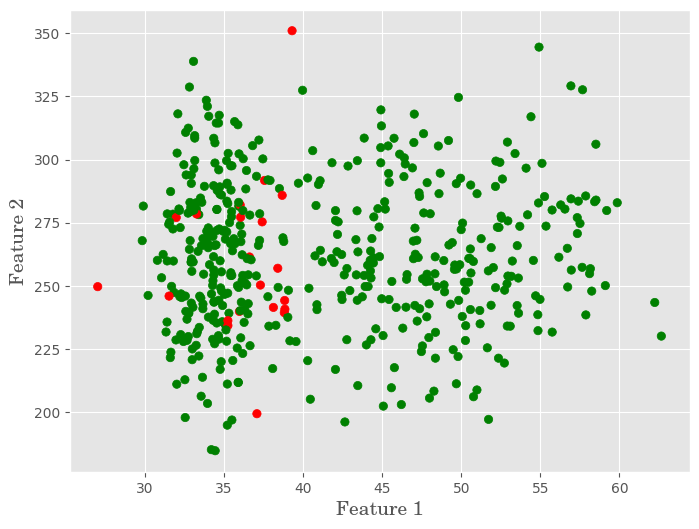

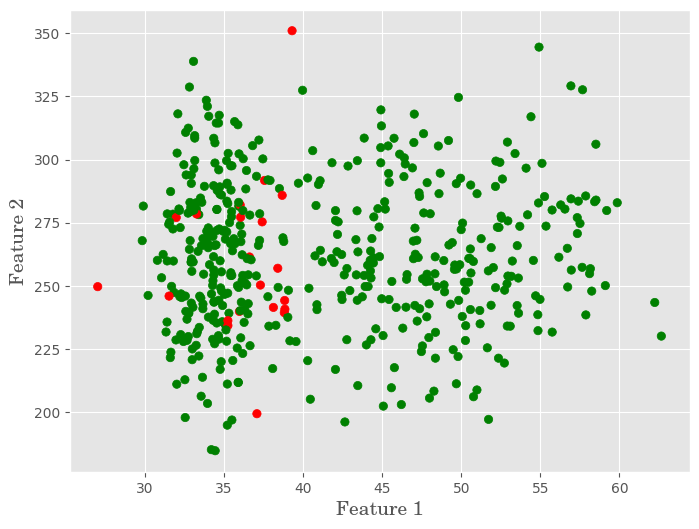

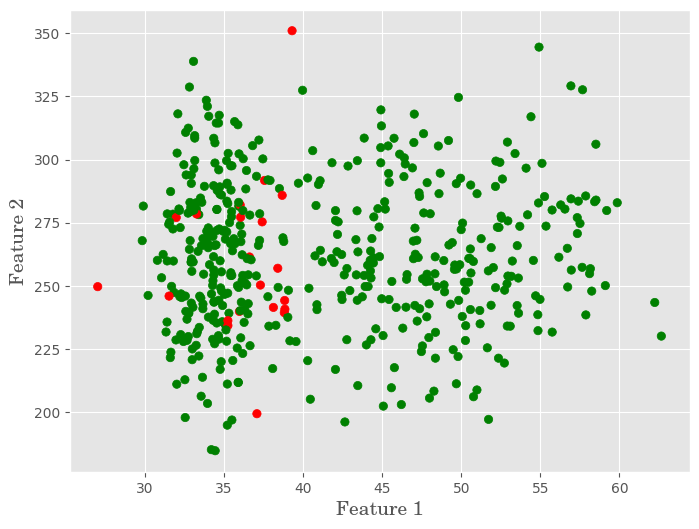

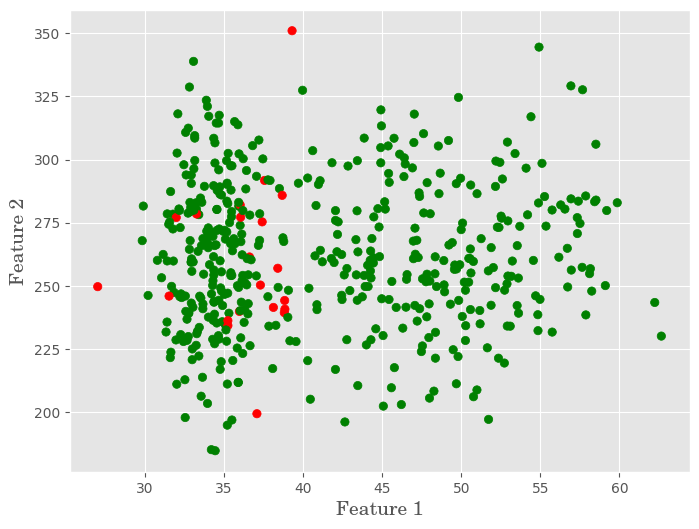

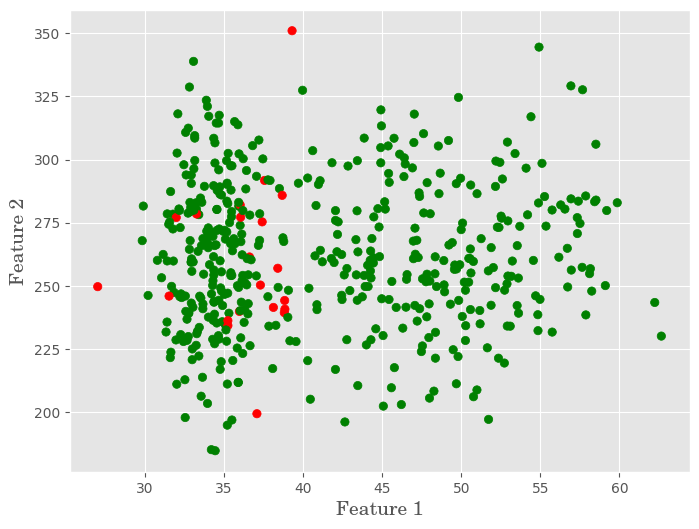

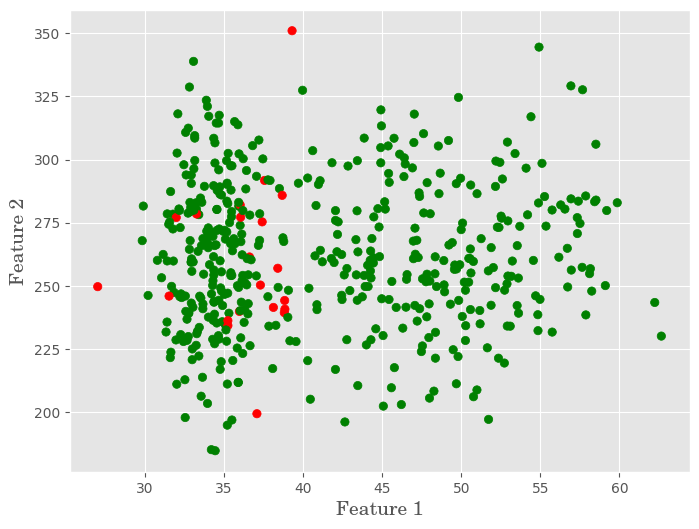

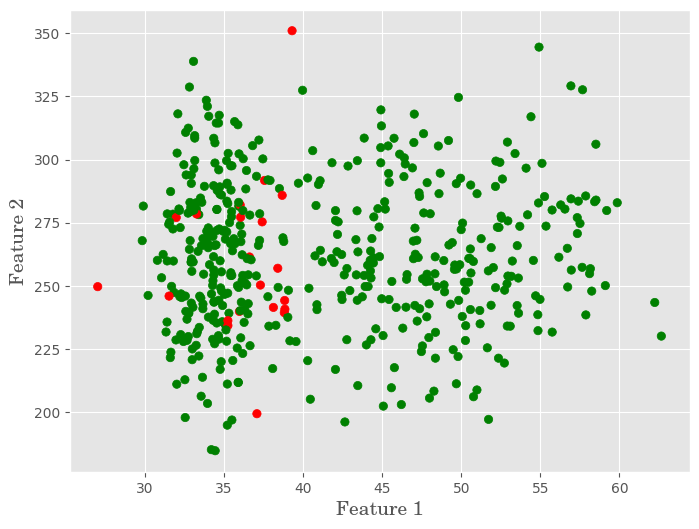

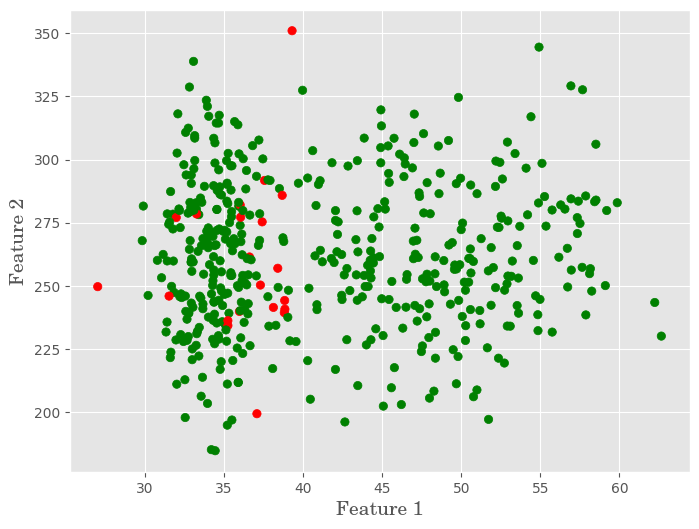

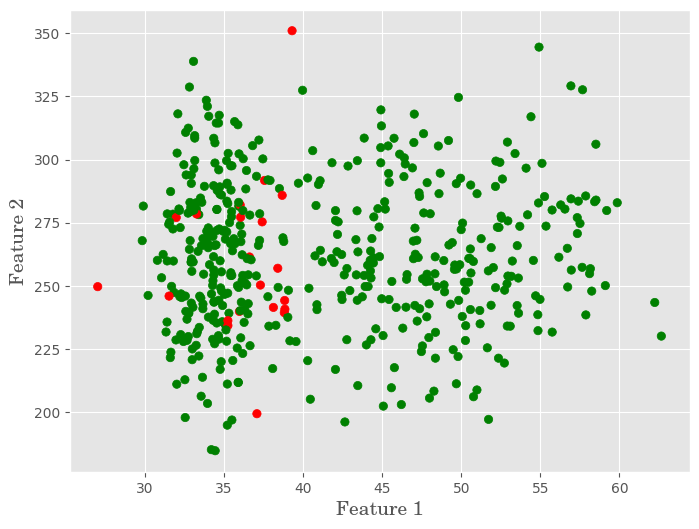

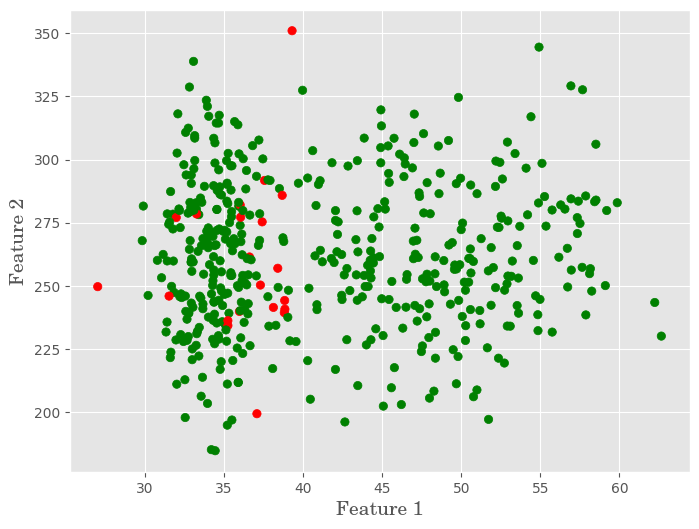

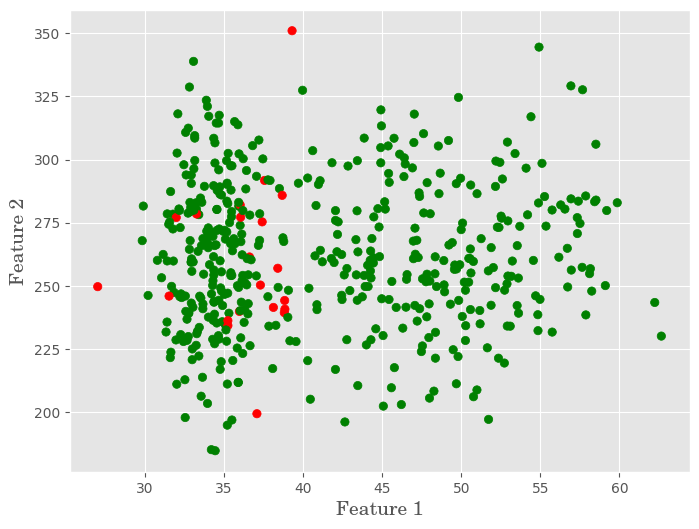

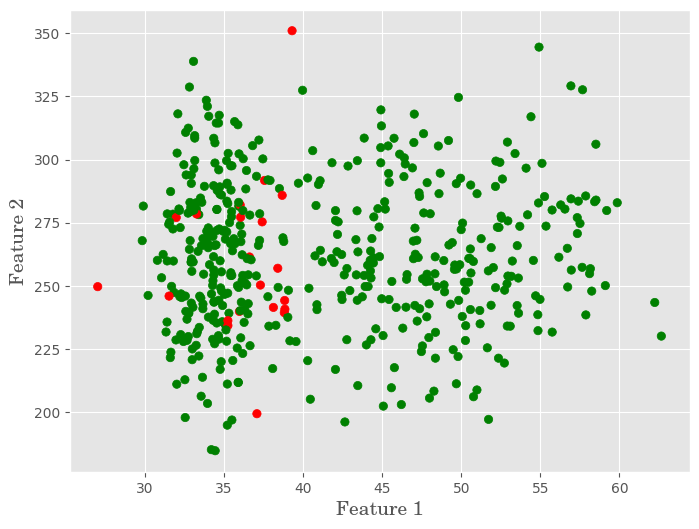

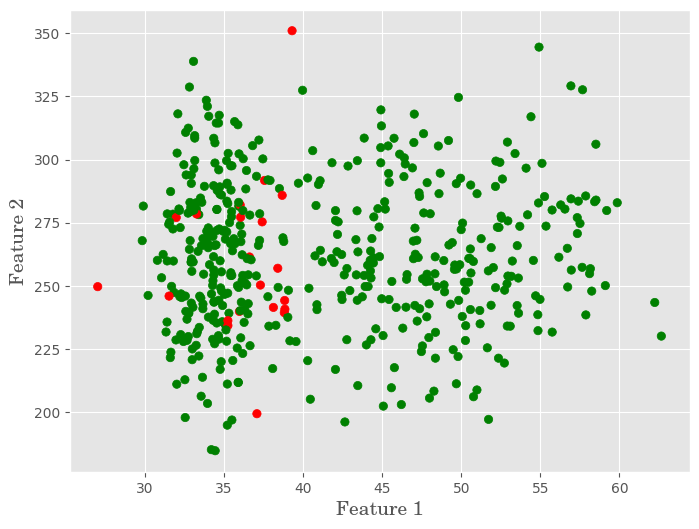

In [137]:
ll = sorted([[round(adjusted_rand_score(z_true, model.z_map),3), int(model.BIC) ,int(model.log_max_post), model.iter_map] for model in Models])[::-1]
print("ARI BIC LogMaxPost MAP_iter")
for i in ll:
    print(*i)
    
# choosing the best model with lowest BIC
least_BIC = 1*np.inf
for model in Models:
    if model.BIC < least_BIC:
        bestModel = model
        least_BIC = model.BIC

    if D == 2:
        
        colors = np.array([x for x in "kbgrbgcmykbgrcmykbgrcmyk"])
        plt.figure(figsize=(8, 6))  # Adjust the size of the plot
        plt.style.use('ggplot')
        plt.xlabel('Feature 1', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
        plt.ylabel('Feature 2',  fontdict={'fontsize': 14, 'fontfamily': 'C059'})

        colors_pref = (z_true ==  bestModel.z_map).tolist()
        for i in range(len(colors_pref)):
            if colors_pref[i] == False:
                colors_pref[i] = "r"
            else:
                colors_pref[i] = "g"
                
        plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors_pref)
        
        # plt.savefig('thesis-results/2D-noise-bayes.png', dpi=300)
        plt.show()
        plt.close()

bayes_assignments = bestModel.z_map

#### With Feature Selection

In [138]:
prior = utils.NIchi2(m_0, k_0, v_0, S_0)

Models = []
Results = []
    
FS = True

features = np.ones((K_initial, D), int)

initial_ass_seed = 25
np.random.seed(initial_ass_seed)
for run in range(training_runs+20):
    print(f"\nRun:  {run+1}")
    starting_assignments = []

    while len(set(starting_assignments)) != K_initial:
        starting_assignments = np.random.randint(0, K_initial, N)
    
    bayesgmm = bayesGM(X, prior, alpha, starting_assignments, FS, features)
    gmmResult = bayesgmm.gibbs_sampler(iterations, run, toPrint=True, savePosterior=False, trueAssignments=z_true)
    
    Models.append(bayesgmm)
    Results.append(gmmResult)



Run:  1
Initial features:
[[1 1]
 [1 1]]
run: 1, iteration:0, K:2, posterior:-1092.854, ARI: -0.002

run: 1, iteration:1, K:2, posterior:-1057.063, ARI: 0.019918980183137473
features:
 [[1 1]
 [1 1]]
0/60               
run: 1, iteration:2, K:2, posterior:-1021.459, ARI: 0.08815570857496871
features:
 [[1 1]
 [1 1]]
1/60               
run: 1, iteration:3, K:2, posterior:-667.249, ARI: 0.5767516488354444
features:
 [[1 1]
 [1 1]]
2/60               
run: 1, iteration:4, K:2, posterior:-287.734, ARI: 0.952480957514709
features:
 [[1 1]
 [1 1]]
3/60               
run: 1, iteration:5, K:2, posterior:-255.311, ARI: 0.9920000001562724
features:
 [[1 1]
 [1 1]]
4/60               
run: 1, iteration:6, K:2, posterior:-256.441, ARI: 0.9681923737408957
features:
 [[1 1]
 [1 1]]
5/60               
run: 1, iteration:7, K:2, posterior:-263.302, ARI: 0.9760961807113047
features:
 [[1 1]
 [1 1]]
6/60               
run: 1, iteration:8, K:2, posterior:-253.348, ARI: 1.0
features:
 [[1 1]
 [1 1]]
7

ARI BIC LogMaxPost MAP_iter
1.0 510 -253 59
1.0 510 -253 58
1.0 510 -253 58
1.0 510 -253 55
1.0 510 -253 54
1.0 510 -253 53
1.0 510 -253 52
1.0 510 -253 46
1.0 510 -253 44
1.0 510 -253 37
1.0 510 -253 34
1.0 510 -253 32
1.0 510 -253 31
1.0 510 -253 27
1.0 510 -253 26
1.0 510 -253 20
1.0 510 -253 20
1.0 510 -253 8
1.0 510 -253 5
0.992 511 -253 21
0.992 511 -253 12


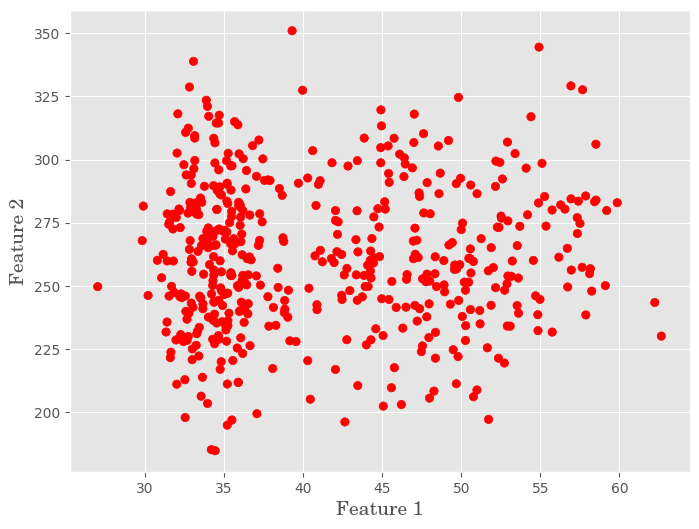

In [139]:
ll = sorted([[round(adjusted_rand_score(z_true, model.z_map),3), int(model.BIC) ,int(model.log_max_post), model.iter_map] for model in Models])[::-1]
print("ARI BIC LogMaxPost MAP_iter")

for i in ll:
    print(*i)
    
# choosing the best model with lowest BIC
least_BIC = 1*np.inf
for model in Models:
    if model.BIC < least_BIC:
        bestModel = model
        least_BIC = model.BIC

colors = np.array([x for x in "kbgrbgcmykbgrcmykbgrcmyk"])
plt.figure(figsize=(8, 6))  # Adjust the size of the plot

plt.xlabel('Feature 1', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
plt.ylabel('Feature 2',  fontdict={'fontsize': 14, 'fontfamily': 'C059'})


colors_pref = (z_true ==  bestModel.z_map).tolist()
for i in range(len(colors_pref)):
    if colors_pref[i] == False:
        colors_pref[i] = "r"
    else:
        colors_pref[i] = "g"
        
plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors_pref)


# plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors[bestModel.z_map].tolist())                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
# plt.savefig('thesis-results/2D-noise-bayes-FS.png', dpi=300)
plt.show()
plt.close()

bayes_assignments_fs = bestModel.z_map

### Results Comparison

1.0

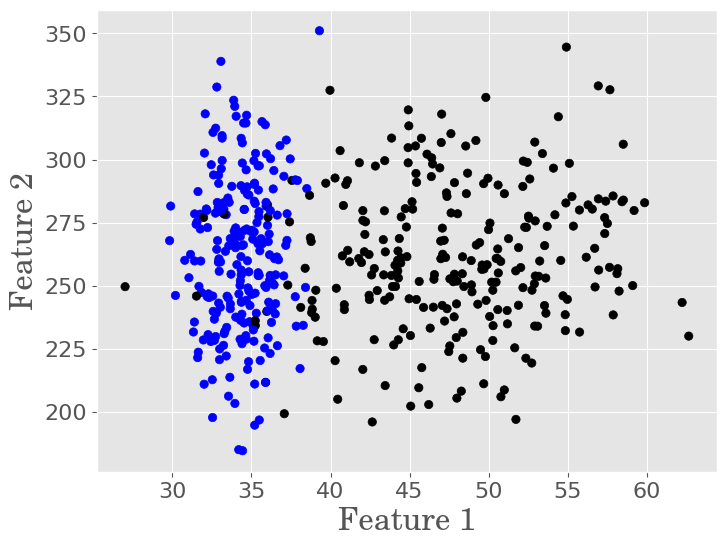

In [163]:
plt.figure(figsize=(8, 6))  # Adjust the size of the plot
colors = np.array([x for x in "kbgrbgcmykbgrcmykbgrcmyk"])
plt.style.use('ggplot')
plt.xlabel('Feature 1', fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.ylabel('Feature 2',  fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('thesis-results/2D-noise-bayes-FS.png', dpi=300)
plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors[bayes_assignments_fs].tolist())  
plt.savefig('thesis-results/2D-noise-bayes-FS.png', dpi=300)
round(adjusted_rand_score(z_true, z_true.tolist()),3)

0.839

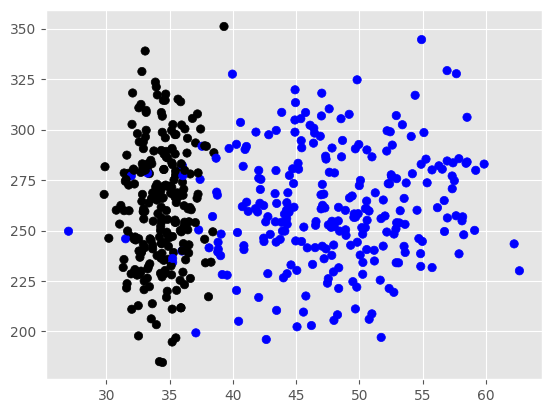

In [141]:
plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors[z_true].tolist())   
round(adjusted_rand_score(z_true, bayes_assignments.tolist()),3)

1.0

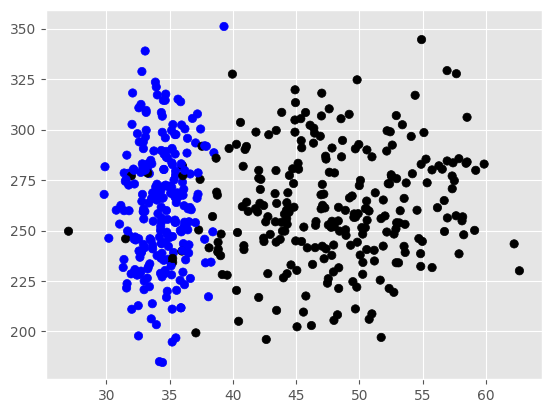

In [142]:
plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors[bayes_assignments_fs].tolist())  
round(adjusted_rand_score(z_true, bayes_assignments_fs.tolist()),3)

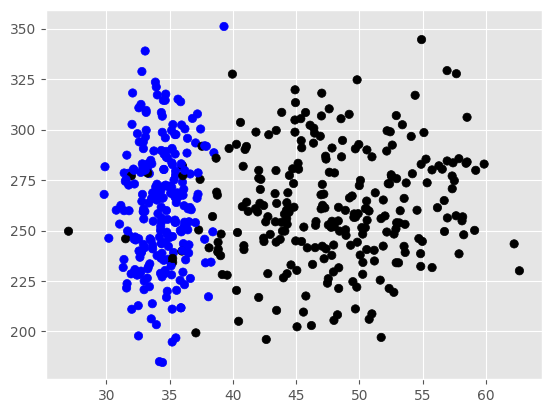

In [143]:
plt.scatter(X_noisey[:, 0], X_noisey[:, 1], color=colors[bayes_assignments_fs - z_true].tolist())

In [26]:
np.count_nonzero(z_true == 0)

238

In [27]:
np.count_nonzero(z_true == 1)

262

In [28]:
np.count_nonzero(z_true == 2)

0